This notebook generates plots for Figure 5 of the Kipoi manuscript.

In [171]:
import numpy as np
import m_kipoi
from copy import deepcopy
import os
import pandas as pd
from plotnine import *
from m_kipoi.utils import read_pkl, write_pkl
import matplotlib
import matplotlib.pyplot as plt
from m_kipoi.config import get_data_dir
from tqdm import tqdm
from m_kipoi.exp.splicing.data import get_dbscsnv_Xy, get_clinvar_ext_Xy

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
ddir = get_data_dir()

In [35]:
# Use these Kipoi models
models = ["MaxEntScan/3prime", "MaxEntScan/5prime", "HAL", "labranchor"]

### Data

#### ClinVar

In [178]:
clinvar_file = f"{ddir}/processed/splicing/clinvar/annotated_vcf/20180429.filtered/clinvar_ext_Xy.pkl"
if os.path.exists(clinvar_file):
    X_clinvar, y_clinvar = read_pkl(clinvar_file)
else:
    X_clinvar, y_clinvar = get_clinvar_ext_Xy()
    write_pkl((X_clinvar, y_clinvar), clinvar_file)

In [166]:
ls {ddir}/processed/splicing/clinvar/annotated_vcf/20180429.filtered/clinvar_ext_Xy.pkl

modeling_df.tsv  models/  VEP.txt.gz


In [37]:
print(y_clinvar.mean())
print(len(y_clinvar))

0.6218811626511189
11663


In [38]:
X_clinvar['early_stop'] = X_clinvar.early_stop.astype(bool)
y_clinvar = y_clinvar[~X_clinvar['early_stop']]
X_clinvar = X_clinvar[~X_clinvar['early_stop']]

In [39]:
# permute

#### dbscSNV

In [40]:
X_dbscsnv, y_dbscsnv = get_dbscsnv_Xy()

________________________________________________________________________________
[Memory] Calling m_kipoi.exp.splicing.data.get_dbscsnv_Xy...
get_dbscsnv_Xy()
__________________________________________________get_dbscsnv_Xy - 41.2s, 0.7min


In [177]:
ls {ddir}/processed/splicing/dbscSNV/annotated_vcf/variants/dbscsnv_Xy.pkl

/data/nasif12/home_if12/avsec/workspace/kipoi/manuscript/m_kipoi/../data/processed/splicing/dbscSNV/annotated_vcf/variants/dbscsnv_Xy.pkl


In [179]:
dbscsnv_file = f"{ddir}/processed/splicing/dbscSNV/annotated_vcf/variants/dbscsnv_Xy.pkl"
if os.path.exists(dbscsnv_file):
    X_dbscsnv, y_dbscsnv = read_pkl(dbscsnv_file)
else:
    X_dbscsnv, y_dbscsnv = get_dbscsnv_Xy()
    write_pkl((X_dbscsnv, y_dbscsnv), dbscsnv_file)

## Features

In [41]:
kipoi_features = [x for m in models for x in X_dbscsnv.columns[X_dbscsnv.columns.str.startswith(m)]]

In [42]:
clinvar_kipoi_features = [x for m in models for x in X_clinvar.columns[X_clinvar.columns.str.startswith(m)]]

In [43]:
#X_clinvar['labranchor_alt'] = np.log(X_clinvar['labranchor_alt'] / (1-X_clinvar['labranchor_alt']))
#X_clinvar['labranchor_ref'] = np.log(X_clinvar['labranchor_ref'] / (1-X_clinvar['labranchor_ref']))

In [44]:
kipoi_features = ['MaxEntScan/3prime_alt',
                 'MaxEntScan/3prime_ref',
                 'MaxEntScan/3prime_isna',
                 'MaxEntScan/5prime_alt',
                 'MaxEntScan/5prime_ref',
                 'MaxEntScan/5prime_isna',
                 'HAL_ref',
                 'HAL_alt',
                 'HAL_isna',
                 'labranchor_logit_alt',
                 'labranchor_logit_ref',
                 'labranchor_isna']

In [45]:
kipoi_na_features = [x for x in kipoi_features if x.endswith("_isna")]

In [46]:
dbscsnv_model_features = ['PWM_ref', 'PWM_alt',
                          'MES_ref', 'MES_alt', 
                          'NNSplice_ref', 'NNSplice_alt', 
                          'HSF_ref', 'HSF_alt', 
                          'GeneSplicer_ref', 'GeneSplicer_alt', 
                          'GENSCAN_ref', 'GENSCAN_alt', 
                          'NetGene2_ref', 'NetGene2_alt', 
                          'SplicePredictor_ref', 'SplicePredictor_alt']

In [47]:
conservation_features = ['phyloP46way_placental', 'phyloP46way_primate', 'CADD_raw', 'CADD_phred']

In [48]:
dbscsnv_dbscsnv_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']

In [49]:
clinvar_cons_feat = ['CADD_raw', 'CADD_phred', 'phyloP46way_placental', 'phyloP46way_primate']
clinvar_dbscSNV_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']
spidex_feat = ['dpsi_max_tissue', 'dpsi_zscore', 'dpsi_max_tissue_isna', 'dpsi_zscore_isna']

In [50]:
dbscsnv_features = dbscsnv_model_features + conservation_features

## Modeling

In [51]:
# Scikit-learn imports
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper

from m_kipoi.metrics import classification_metric, classification_metrics, BootstrapMetric, MetricsOrderedDict

In [52]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X).fillna(0).copy()

In [53]:
def preproc(features):
    """Pre-processing pipeline
    """
    return DataFrameMapper([
            (features, [ZeroImputer(), 
                        sklearn.preprocessing.StandardScaler(),
                       ]),
        ])

In [54]:
# model = LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)
# LogReg is completely fine here as D < 20 < 1000 < N
model = LogisticRegression()

In [55]:
np.random.seed(42)

In [56]:
def evaluate(df, y, features, model, model_name):
        perm = np.random.permutation(len(df))  # permute rows
        ret = cross_validate(Pipeline([('preproc', preproc(features)), 
                                       ('model', model)]), 
                             df.iloc[perm], y[perm], scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=10, return_train_score=True)
        means = pd.DataFrame(ret).describe().loc['mean']
        means.index = "mean_" + means.index
        sds = pd.DataFrame(ret).describe().loc['std']
        sds.index = "std_" + sds.index
        return pd.DataFrame([{**dict(means), **dict(sds), "model_name": model_name}])

In [57]:
def run_model_groups(df, y, model_groups,
                     model=LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)):
    res = []
    use_features = []
    for mg in tqdm(model_groups):
        use_features += [f for f in df.columns if f.startswith(mg)]
        if mg=='labranchor':
            mg = 'labranchor (KipoiSplice4)'
        res.append(evaluate(df, y, use_features, model, model_name=mg))
    return pd.concat(res)

In [58]:
res_dbscsnv = run_model_groups(X_dbscsnv, y_dbscsnv, models, model=model)

100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


In [59]:
kipoi_features + conservation_features

['MaxEntScan/3prime_alt',
 'MaxEntScan/3prime_ref',
 'MaxEntScan/3prime_isna',
 'MaxEntScan/5prime_alt',
 'MaxEntScan/5prime_ref',
 'MaxEntScan/5prime_isna',
 'HAL_ref',
 'HAL_alt',
 'HAL_isna',
 'labranchor_logit_alt',
 'labranchor_logit_ref',
 'labranchor_isna',
 'phyloP46way_placental',
 'phyloP46way_primate',
 'CADD_raw',
 'CADD_phred']

In [60]:
X_dbscsnv.columns

Index(['Unnamed: 0', 'Source', 'Chr', 'Position', 'Ref', 'Alt', 'Type', 'Strand', 'Splice_site',
       'Distance', 'PWM_ref', 'PWM_alt', 'MES_ref', 'MES_alt', 'NNSplice_ref', 'NNSplice_alt',
       'HSF_ref', 'HSF_alt', 'GeneSplicer_ref', 'GeneSplicer_alt', 'GENSCAN_ref', 'GENSCAN_alt',
       'NetGene2_ref', 'NetGene2_alt', 'SplicePredictor_ref', 'SplicePredictor_alt',
       'phyloP46way_placental', 'phyloP46way_primate', 'CADD_raw', 'CADD_phred', 'variant_id',
       'MaxEntScan/3prime_ref', 'MaxEntScan/3prime_diff', 'MaxEntScan/3prime_alt',
       'MaxEntScan/5prime_ref', 'MaxEntScan/5prime_diff', 'MaxEntScan/5prime_alt',
       'labranchor_logit_ref', 'labranchor_logit_alt', 'labranchor_ref', 'labranchor_alt',
       'labranchor_diff', 'HAL_ref', 'HAL_diff', 'HAL_alt', 'MaxEntScan/3prime_isna',
       'MaxEntScan/5prime_isna', 'labranchor_isna', 'HAL_isna', 'end', 'dpsi_max_tissue',
       'dpsi_zscore', 'dpsi_max_tissue_isna', 'dpsi_zscore_isna', 'RefSeq?', 'Ensembl?',
       'R

In [61]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, kipoi_features + conservation_features, 
                                          model=model,
                                          model_name="KipoiSplice4 w/ cons."))

In [62]:
#res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_model_features,
#                                          model=model,
#                                          model_name="dbscSNV w/o cons."))

In [63]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_model_features + conservation_features,
                                          model=model,
                                          model_name="dbscSNV"))

In [64]:
#res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_dbscsnv_feat,
#                                          model=model,
#                                          model_name="dbscSNV rf_score"))

In [65]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, spidex_feat,
                                          model=model,
                                          model_name="SPIDEX"))

In [66]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, spidex_feat + clinvar_cons_feat,
                                          model=model,
                                          model_name="SPIDEX w/ cons."))

In [118]:
res_clinvar = run_model_groups(X_clinvar, y_clinvar, models, model=model)

100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


In [119]:
clinvar_kipoi_features

['MaxEntScan/3prime_ref',
 'MaxEntScan/3prime_alt',
 'MaxEntScan/3prime_isna',
 'MaxEntScan/5prime_ref',
 'MaxEntScan/5prime_alt',
 'MaxEntScan/5prime_isna',
 'HAL_ref',
 'HAL_alt',
 'HAL_isna',
 'labranchor_logit_ref',
 'labranchor_logit_alt',
 'labranchor_ref',
 'labranchor_alt',
 'labranchor_isna']

In [120]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, clinvar_kipoi_features + clinvar_cons_feat, 
                                          model=model,
                                          model_name="KipoiSplice4 w/ cons."))

In [121]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, dbscsnv_dbscsnv_feat,
                                          model=model,
                                          model_name="dbscSNV"))

In [122]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat,
                                          model=model,
                                          model_name="SPIDEX"))

In [123]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat + clinvar_cons_feat,
                                          model=model,
                                          model_name="SPIDEX w/ cons."))

In [124]:
res_clinvar

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_roc_auc,mean_train_accuracy,mean_train_roc_auc,model_name,std_fit_time,std_score_time,std_test_accuracy,std_test_roc_auc,std_train_accuracy,std_train_roc_auc
0,0.0453,0.0066,0.7458,0.7794,0.7457,0.7797,MaxEntScan/3prime,0.0193,0.0029,0.0147,0.0161,0.0017,0.0018
0,0.0527,0.0076,0.8326,0.8958,0.8328,0.8965,MaxEntScan/5prime,0.0211,0.0038,0.0100,0.0057,0.0013,0.0007
0,0.0886,0.0282,0.8332,0.9054,0.8333,0.9061,HAL,0.0328,0.0130,0.0159,0.0136,0.0016,0.0016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0597,0.0101,0.8580,0.9158,0.8580,0.9158,dbscSNV,0.0286,0.0059,0.0090,0.0061,0.0011,0.0007
0,0.0740,0.0108,0.7539,0.8210,0.7540,0.8208,SPIDEX,0.0300,0.0060,0.0151,0.0147,0.0019,0.0016
0,0.1895,0.0333,0.8530,0.9205,0.8532,0.9205,SPIDEX w/ cons.,0.0738,0.0227,0.0079,0.0056,0.0009,0.0007


In [125]:
y_clinvar.mean()

0.5888940737284181

In [126]:
np.sum(y_clinvar==0)

4405

In [127]:
y_clinvar.size

10715

In [128]:
X_clinvar[clinvar_kipoi_features].describe()

,MaxEntScan/3prime_ref,MaxEntScan/3prime_alt,MaxEntScan/3prime_isna,MaxEntScan/5prime_ref,MaxEntScan/5prime_alt,MaxEntScan/5prime_isna,HAL_ref,HAL_alt,HAL_isna,labranchor_logit_ref,labranchor_logit_alt,labranchor_ref,labranchor_alt,labranchor_isna
count,4475.0000,4475.0000,10715.0000,3562.0000,3562.0000,10715.0000,6588.0000,6588.0000,10715.0000,4381.0000,4381.0000,4381.0000,4381.0000,10715.0000
mean,8.3806,5.0437,0.5824,8.1955,2.0892,0.6676,13.7271,9.9510,0.3852,-1.2202,-1.1731,0.3220,0.3189,0.5911
std,2.9834,4.9767,0.4932,2.6756,4.0857,0.4711,3.1775,5.4993,0.4867,1.9516,1.7940,0.2698,0.2599,0.4916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50%,8.6842,6.1099,1.0000,8.6801,1.4502,1.0000,13.7792,11.0239,0.0000,-1.1014,-1.1175,0.2495,0.2465,1.0000
75%,10.2223,9.1340,1.0000,9.7877,4.1052,1.0000,15.7671,14.3217,1.0000,0.0168,-0.0416,0.5042,0.4896,1.0000
max,14.9268,14.7292,1.0000,11.8065,11.8065,1.0000,26.8472,26.8472,1.0000,3.7983,3.6642,0.9781,0.9750,1.0000


### Plot

In [129]:
import matplotlib.pyplot as plt

In [130]:
cm = plt.get_cmap('tab10')

In [131]:
list(res_dbscsnv.model_name[:5])

['MaxEntScan/3prime',
 'MaxEntScan/5prime',
 'HAL',
 'labranchor (KipoiSplice4)',
 'KipoiSplice4 w/ cons.']

In [132]:
list(res_dbscsnv.model_name[5:])

['dbscSNV', 'SPIDEX', 'SPIDEX w/ cons.']

In [133]:
kipoi_model_names = [
    'MaxEntScan/3prime',
     '+MaxEntScan/5prime',
     '+HAL',
     '+labranchor',
     '+conservation (KipoiSplice4)']

In [134]:
#res_clinvar = res_clinvar.iloc[:-2]

In [135]:
res_clinvar

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_roc_auc,mean_train_accuracy,mean_train_roc_auc,model_name,std_fit_time,std_score_time,std_test_accuracy,std_test_roc_auc,std_train_accuracy,std_train_roc_auc
0,0.0453,0.0066,0.7458,0.7794,0.7457,0.7797,MaxEntScan/3prime,0.0193,0.0029,0.0147,0.0161,0.0017,0.0018
0,0.0527,0.0076,0.8326,0.8958,0.8328,0.8965,MaxEntScan/5prime,0.0211,0.0038,0.0100,0.0057,0.0013,0.0007
0,0.0886,0.0282,0.8332,0.9054,0.8333,0.9061,HAL,0.0328,0.0130,0.0159,0.0136,0.0016,0.0016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0597,0.0101,0.8580,0.9158,0.8580,0.9158,dbscSNV,0.0286,0.0059,0.0090,0.0061,0.0011,0.0007
0,0.0740,0.0108,0.7539,0.8210,0.7540,0.8208,SPIDEX,0.0300,0.0060,0.0151,0.0147,0.0019,0.0016
0,0.1895,0.0333,0.8530,0.9205,0.8532,0.9205,SPIDEX w/ cons.,0.0738,0.0227,0.0079,0.0056,0.0009,0.0007


In [136]:
other_model_names = ['dbscSNV', 'SPIDEX', 'SPIDEX+conservation']

In [137]:
cv_other_model_names = list(res_clinvar.model_name[5:])

In [138]:
res_clinvar.mean_test_roc_auc[5:]

0    0.9158
0    0.8210
0    0.9205
Name: mean_test_roc_auc, dtype: float64

In [139]:
other_model_names

['dbscSNV', 'SPIDEX', 'SPIDEX+conservation']

In [140]:
res_clinvar.std_test_roc_auc[5:]

0    0.0061
0    0.0147
0    0.0056
Name: std_test_roc_auc, dtype: float64

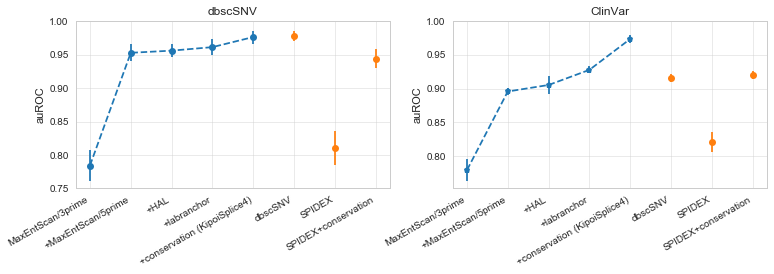

In [159]:
fig=plt.figure(figsize=(12, 4))
fig.subplots_adjust(bottom=0.3, left=0.1)
plt.subplot(121)
col1 = cm.colors[0]
col2 = cm.colors[1]
tilt = 30
plt.errorbar(kipoi_model_names, res_dbscsnv.mean_test_roc_auc[:5], yerr=res_dbscsnv.std_test_roc_auc[:5], fmt='o--', color=col1)
#plt.errorbar(res_dbscsnv.model_name[4:5], res_dbscsnv.mean_test_roc_auc[4:5], yerr=res_dbscsnv.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_dbscsnv.mean_test_roc_auc[5:], yerr=res_dbscsnv.std_test_roc_auc[5:], fmt='o', color=col2)
plt.ylabel("auROC")
#plt.errorbar(["asd"], [.9], yerr=[.1], fmt='o--')
plt.title("dbscSNV")
plt.ylim((None, 1))
plt.grid(alpha=0.4)
plt.xticks(rotation=tilt, horizontalalignment="right");
plt.subplot(122)
plt.errorbar(kipoi_model_names, res_clinvar.mean_test_roc_auc[:5], yerr=res_clinvar.std_test_roc_auc[:5], fmt='p--', color=col1)
#plt.errorbar(res_clinvar.model_name[4:5], res_clinvar.mean_test_roc_auc[4:5], yerr=res_clinvar.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_clinvar.mean_test_roc_auc[5:], yerr=res_clinvar.std_test_roc_auc[5:], fmt='o', color=col2)
plt.title("ClinVar")
plt.grid(alpha=0.4)
plt.ylim((None, 1))
plt.ylabel("auROC")
plt.xticks(rotation=tilt, horizontalalignment="right");
#plt.tight_layout(h_pad=0);
plt.savefig('plots/fig5c_clinvar_20180429.png', dpi=600)
plt.savefig('plots/fig5c_clinvar_20180429.pdf', dpi=600)
plt.close(fig)    # close the figure
fig

In [142]:
isna_clinvar = X_clinvar.filter(like="_isna", axis=1)

In [143]:
isna_clinvar['KipoiSplice4_isna'] = isna_clinvar[pd.Series(models)+"_isna"].min(axis=1)
isna_clinvar = isna_clinvar.mean().sort_index().reset_index().rename(columns={"index": "Method", 0: "NA_frac"})
isna_clinvar['Dataset'] = "ClinVar"
isna_clinvar['Method'] = isna_clinvar['Method'].str.replace("_isna", "")

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [144]:
isna_dbscsnv = X_dbscsnv.iloc[:,~X_dbscsnv.columns.str.contains("rbp_eclip")].filter(like="_isna", axis=1)
isna_dbscsnv['KipoiSplice4_isna'] = isna_dbscsnv[pd.Series(models)+"_isna"].min(axis=1)
isna_dbscsnv = isna_dbscsnv.mean().sort_index().reset_index().rename(columns={"index": "Method", 0: "NA_frac"})
isna_dbscsnv['Dataset'] = "dbscSNV"
isna_dbscsnv['Method'] = isna_dbscsnv['Method'].str.replace("_isna", "")

In [145]:
df_isna = pd.concat([isna_clinvar, isna_dbscsnv])

In [146]:
df_isna = df_isna[~df_isna.Method.str.contains("ada_score")]
df_isna = df_isna[~df_isna.Method.str.contains("max_tissue")]

In [147]:
df_isna['Method'] = df_isna.Method.replace({"dbscSNV_rf_score": "dbscSNV", 'dpsi_zscore': 'SPIDEX'})

In [148]:
methods = df_isna.Method.unique()[::-1].tolist()
datasets = df_isna.Dataset.unique()[::-1].tolist()

In [149]:
methods =['MaxEntScan/3prime',
          'MaxEntScan/5prime',
          'HAL',
          'labranchor',
          'Kipoi4',
          'dbscSNV',
          'SPIDEX'][::-1]

In [150]:
import plotnine

In [151]:
df_isna

,Method,NA_frac,Dataset
0,HAL,0.3852,ClinVar
1,KipoiSplice4,0.0000,ClinVar
2,MaxEntScan/3prime,0.5824,ClinVar
...,...,...,...
5,dbscSNV,0.0321,dbscSNV
7,SPIDEX,0.0727,dbscSNV
8,labranchor,0.6346,dbscSNV


In [152]:
methods

['SPIDEX',
 'dbscSNV',
 'Kipoi4',
 'labranchor',
 'HAL',
 'MaxEntScan/5prime',
 'MaxEntScan/3prime']

In [153]:
df_isna['Method'] = pd.Categorical(df_isna.Method, methods)

In [154]:
df_isna['Dataset'] = pd.Categorical(df_isna.Dataset, datasets)

In [155]:
df_isna = df_isna.reset_index()

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplica

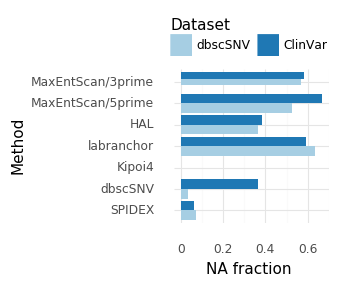

<ggplot: (-9223363258659207925)>

In [160]:
plotnine.options.figure_size = (2,2)
gplt = ggplot(aes(x="Method", y="NA_frac", fill="Dataset"), df_isna) + \
    geom_bar(stat='identity', position='dodge') + \
    ylab("NA fraction") + \
    theme_minimal() + \
    theme(legend_box_margin=0,
          legend_direction='horizontal', 
          legend_position='top') + \
    coord_flip()  + \
        scale_fill_brewer("qual", 3)
gplt

In [161]:
gplt.save("plots/fig5b_clinvar_20180429.pdf", dpi=600)
gplt.save("plots/fig5b_clinvar_20180429.png", dpi=600)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 2 x 2 in image.
  from_inches(height, units), units))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: plots/fig5b_clinvar_20180429.pdf
  warn('Filename: {}'.format(filename))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: F